# Structure Function Turbulent Data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import torch
from turboflow.models.rff import RFFNet
from turboflow.dataloaders import Turbo2D_simple, load_turbo2D_simple_numpy
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

# set up cuda 
torch.cuda.is_available()
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [3]:
# ds=downsampling factor
Xlr, Ulr = load_turbo2D_simple_numpy(ds=4) # low resolution (64x64)
Xmr, Umr = load_turbo2D_simple_numpy(ds=2) # mid resolution (128x128)
Xhr, Uhr = load_turbo2D_simple_numpy(ds=1) # high (max) resolution (256x256)

L = int(Xlr.shape[0]**0.5)
M = int(Xmr.shape[0]**0.5)
H = int(Xhr.shape[0]**0.5)

Y shape (64, 64, 2)
Y min, max: -2.365612 2.941536
after normalization, Y min, max: -0.8042097733972999 1.0
Y shape (128, 128, 2)
Y min, max: -2.371183 2.985797
after normalization, Y min, max: -0.7941541236728418 1.0
Y shape (256, 256, 2)
Y min, max: -2.382122 2.999472
after normalization, Y min, max: -0.7941804424245333 1.0


In [ ]:
from turboflow.models.rff import RFFNet

# model (RFF + MLP)
fft_scale = 10
fft_nfeat = 256
nin = 2  # = x and y coordinates
nout = 2 # = ux and uy components
mlp_layers = [nin*fft_nfeat] + [256]*3 + [nout]

rffnet = RFFNet('RFFNet', mlp_layers, fft_nfeat, fft_scale)

# training data
path_to_data = '../data/2021-Turb2D_velocities.npy'
trainset = Turbo2D_simple(path_to_data, device, ds=4, img=42)
trainloader = DataLoader(trainset, batch_size=6666, shuffle=False)

# TRAIN!
rffnet.to(device)
rffnet.fit(trainloader, epochs=1000) # we are not afraid to overfit the data, this is coord-based MLP!

In [ ]:
from turboflow.models.phyrff_soft import PiRFFNet

# model (RFF + MLP)
fft_scale = 10
fft_nfeat = 256
nin = 2
nout = 2
mlp_layers = [nin*fft_nfeat] + [256]*3 + [nout]

pirffntet = PiRFFNet('PIRFFNet', mlp_layers, fft_nfeat, fft_scale)

# training data
path_to_data = '../data/2021-Turb2D_velocities.npy'
trainset = Turbo2D_simple(path_to_data, device, img=42)
trainloader = DataLoader(trainset, batch_size=6666, shuffle=False)

# TRAIN!
pirffntet.to(device)
pirffntet.fit(trainloader, epochs=2000)

In [4]:
# training data
path_to_data = '../data/2021-Turb2D_velocities.npy'
trainset = Turbo2D_simple(path_to_data, device, ds=4, img=42)
trainloader = DataLoader(trainset, batch_size=6666, shuffle=False)

X, y = trainset[:5]
delta_x = (X[2,1] - X[1,1]).item()
smallest_increment = delta_x/4

Dataset Turbo2D, img # 42
(64, 64, 2)
(64, 64, 2)
Original size 64
Y shape (64, 64, 2)
Y min, max: -2.365612 2.941536
after normalization, Y min, max: -0.8042097733972999 1.0


Structure Function

In [ ]:
print(Uhr)
nx, ny = Uhr.reshape(H,H,2)[:,:,0].shape

U2h = np.concatenate([Uhr.reshape(H,H,2)]*2, axis=1)
print(U2h.shape)
U2v = np.concatenate([Uhr.reshape(H,H,2)]*2, axis=0)
print(U2v.shape)
U2d = np.concatenate([U2h, U2h], axis=0)
print(U2d.shape)

increments = np.arange(H)
sfun = np.zeros((H,3))

Uhr_sq = Uhr.reshape(H,H,2)

for d in increments:
    
    # horizontal axis 
    diff_h = (U2h[:,d:H+d,:] - Uhr_sq)**2
    diff_h = diff_h[1]
    
    # vertical axis 
    diff_v = (U2v[d:H+d,:,:] - Uhr_sq)**2
    diff_v = diff_v[0]
    
    # diagonal axis
    diff_d = (U2d[d:H+d,d:H+d,:] - Uhr_sq)**2
    diff_d = (diff_d[0]+diff_d[1])/2
    
    sfun[d,0] = diff_h.mean()
    sfun[d,1] = diff_v.mean()
    sfun[d,2] = diff_d.mean()

c = 0.25
plt.loglog(sfun[:,0], label='horz')
plt.loglog(sfun[:,1], label='vert')
plt.loglog(sfun[:,2], label='diag')
plt.loglog(np.arange(nx//4), c*0.00275*np.arange(nx//4)**2, '--', label='model')
plt.legend()
plt.show()

In [ ]:
del pirffntet
del rffnet
torch.cuda.empty_cache()

In [12]:
from turboflow.models.phyrff_sfun import SfunRFFNet

# model (RFF + MLP)
fft_scale = 10
fft_nfeat = 256
nin = 2  # = x and y coordinates
nout = 2 # = ux and uy components
mlp_layers = [nin*fft_nfeat] + [256]*4 + [nout]

lam_pde = 1e-4
lam_sfun = .5e-4

# model
n_centers = 20 # 100 too much
n_increments = 10
sfunrffnet = SfunRFFNet('SfunRFFNet', mlp_layers, fft_nfeat, fft_scale,
                        lam_pde, lam_sfun,
                        smallest_increment = smallest_increment,
                        n_centers=n_centers, n_increments=n_increments)

sfunrffnet.to(device)
sfunrffnet.fit(trainloader, epochs=3000) # we are not afraid to overfit the data, this is coord-based MLP!

Epoch: 100, Loss: (0.030505 + 0.002062 + 0.000162) = 0.032730
Epoch: 200, Loss: (0.022306 + 0.000724 + 0.000116) = 0.023146
Epoch: 300, Loss: (0.014444 + 0.000823 + 0.000119) = 0.015386
Epoch: 400, Loss: (0.007235 + 0.001158 + 0.000094) = 0.008488
Epoch: 500, Loss: (0.003736 + 0.001144 + 0.000108) = 0.004989
Epoch: 600, Loss: (0.002395 + 0.001021 + 0.000121) = 0.003537
Epoch: 700, Loss: (0.001795 + 0.001019 + 0.000151) = 0.002965
Epoch: 800, Loss: (0.001466 + 0.001293 + 0.000126) = 0.002885
Epoch: 900, Loss: (0.001251 + 0.000835 + 0.000125) = 0.002212
Epoch: 1000, Loss: (0.001099 + 0.000858 + 0.000158) = 0.002116
Epoch: 1100, Loss: (0.000982 + 0.000784 + 0.000133) = 0.001899
Epoch: 1200, Loss: (0.000896 + 0.001398 + 0.000146) = 0.002440
Epoch: 1300, Loss: (0.000821 + 0.001183 + 0.000173) = 0.002177
Epoch: 1400, Loss: (0.000753 + 0.001054 + 0.000099) = 0.001907
Epoch: 1500, Loss: (0.000695 + 0.000889 + 0.000115) = 0.001699
Epoch: 1600, Loss: (0.000642 + 0.000986 + 0.000117) = 0.001746
E

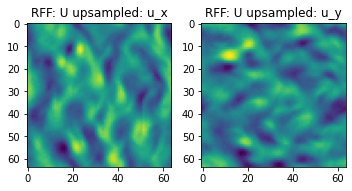

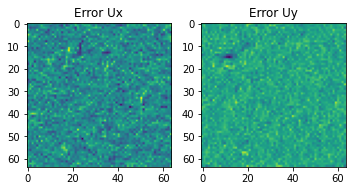

In [13]:
x = torch.from_numpy(Xlr).float().contiguous().to(device)

sfunrffnet.eval().to(device)
pred = sfunrffnet(x)
Udfphy = pred.cpu().detach().numpy().squeeze().reshape(L,L,2)

plt.figure(figsize=(5,5))
plt.subplot(121)
plt.title('RFF: U upsampled: u_x')
plt.imshow(Udfphy[:,:,0])
plt.subplot(122)
plt.title('RFF: U upsampled: u_y')
plt.imshow(Udfphy[:,:,1])
plt.tight_layout()
plt.show()


plt.figure(figsize=(5,5))
plt.subplot(121)
plt.title('Error Ux')
plt.imshow(Udfphy[:,:,0] - Ulr.reshape(L,L,2)[:,:,0])
plt.subplot(122)
plt.title('Error Uy')
plt.imshow(Udfphy[:,:,1] - Ulr.reshape(L,L,2)[:,:,1])
plt.tight_layout()
plt.show()

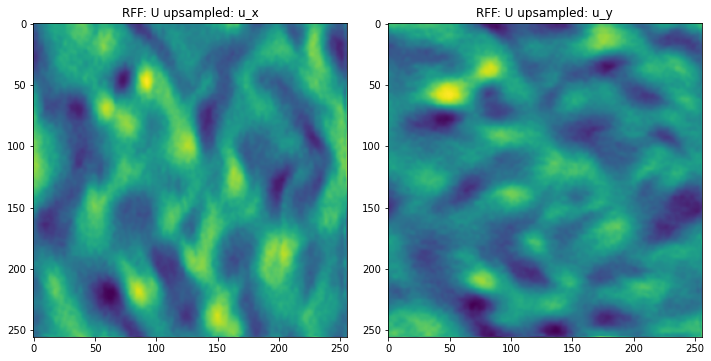

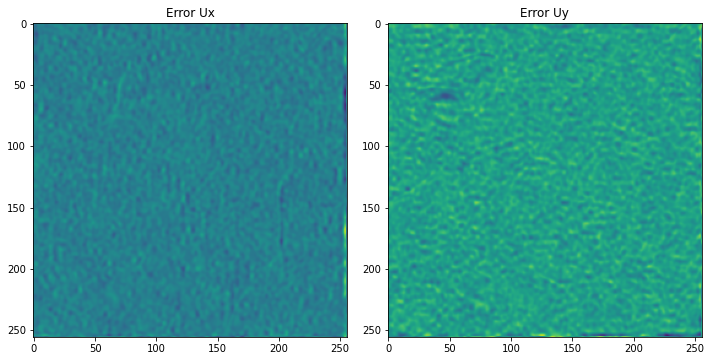

In [20]:
x = torch.from_numpy(Xhr).float().contiguous().to(device)

sfunrffnet.eval().to(device)
pred = sfunrffnet(x)
Usfun = pred.cpu().detach().numpy().squeeze().reshape(H,H,2)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title('RFF: U upsampled: u_x')
plt.imshow(Usfun[:,:,0])
plt.subplot(122)
plt.title('RFF: U upsampled: u_y')
plt.imshow(Usfun[:,:,1])
plt.tight_layout()
plt.show()


plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title('Error Ux')
plt.imshow(Usfun[:,:,0] - Uhr.reshape(H,H,2)[:,:,0])
plt.subplot(122)
plt.title('Error Uy')
plt.imshow(Usfun[:,:,1] - Uhr.reshape(H,H,2)[:,:,1])
plt.tight_layout()
plt.show()

In [15]:
x = torch.from_numpy(Xhr).float().contiguous().to(device)

Upde = pirffntet(x).cpu().detach().numpy().squeeze()
Usfun = sfunrffnet(x).cpu().detach().numpy().squeeze()
Urff = rffnet(x).cpu().detach().numpy().squeeze()

NameError: name 'pirffntet' is not defined

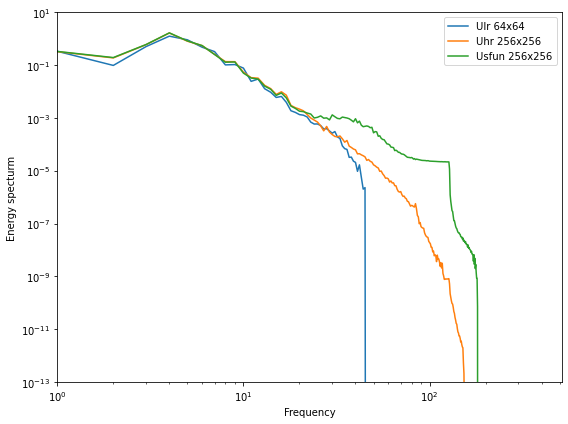

In [21]:
from turboflow.utils import phy_utils as phy

fig, axs = plt.subplots(1,1,figsize=(8,6))
axs.loglog(np.arange(len(phy.powerspec(Ulr.reshape(L,L,2)[:,:,1]))), 
                         phy.powerspec(Ulr.reshape(L,L,2)[:,:,1]), label='Ulr 64x64')
axs.loglog(np.arange(len(phy.powerspec(Uhr.reshape(H,H,2)[:,:,0]))), 
                         phy.powerspec(Uhr.reshape(H,H,2)[:,:,0]), label='Uhr 256x256')
# axs.loglog(np.arange(len(phy.powerspec(Urff.reshape(H,H,2)[:,:,0]))), 
#                          phy.powerspec(Urff.reshape(H,H,2)[:,:,0]), label='Urff 256x256')
# axs.loglog(np.arange(len(phy.powerspec(Upde.reshape(H,H,2)[:,:,0]))), 
#                          phy.powerspec(Upde.reshape(H,H,2)[:,:,0]), label='Upde 256x256')
axs.loglog(np.arange(len(phy.powerspec(Usfun.reshape(H,H,2)[:,:,0]))), 
                         phy.powerspec(Usfun.reshape(H,H,2)[:,:,0]), label='Usfun 256x256')
axs.set_ylim(10**(-13), 10)
axs.set_xlim(1, 512)
axs.legend()
plt.ylabel('Energy specturm')
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

In [17]:
# Let s zoom in it!
ngrid = 256
coords = np.linspace(0.1, 0.4, ngrid)
coords = np.stack(np.meshgrid(coords, coords), -1) # X x Y x 2
coords = coords.reshape(ngrid*ngrid,2)
print(coords.shape)

x = torch.from_numpy(coords).float().contiguous().to(device)

sfunrffnet.eval().to(device)
pred = sfunrffnet(x)
pred = pred.cpu().detach().numpy().squeeze().reshape(ngrid,ngrid,2)

plt.figure(figsize=(5,5))
plt.imshow(pred[:,:,0])
plt.show()

s = 6
plt.figure(figsize=((5,5))
plt.quiver(coords.reshape(ngrid,ngrid,2)[::s,::s,0],
           coords.reshape(ngrid,ngrid,2)[::s,::s,1],
           pred[::s,::s,0],pred[::s,::s,1])

SyntaxError: invalid syntax (3830272633.py, line 20)

(256, 512, 2)
(512, 256, 2)
(512, 512, 2)


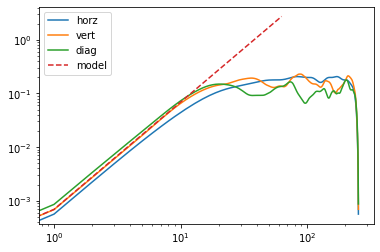

In [18]:
nx, ny = Uhr.reshape(H,H,2)[:,:,0].shape

U2h = np.concatenate([Uhr.reshape(H,H,2)]*2, axis=1)
print(U2h.shape)
U2v = np.concatenate([Uhr.reshape(H,H,2)]*2, axis=0)
print(U2v.shape)
U2d = np.concatenate([U2h, U2h], axis=0)
print(U2d.shape)

increments = np.arange(H)
sfun = np.zeros((H,3))

Uhr_sq = Uhr.reshape(H,H,2)

for d in increments:
    
    # horizontal axis 
    diff_h = (U2h[:,d:H+d,:] - Uhr_sq)**2
    diff_h = diff_h[1]
    
    # vertical axis 
    diff_v = (U2v[d:H+d,:,:] - Uhr_sq)**2
    diff_v = diff_v[0]
    
    # diagonal axis
    diff_d = (U2d[d:H+d,d:H+d,:] - Uhr_sq)**2
    diff_d = (diff_d[0]+diff_d[1])/2
    
    sfun[d,0] = diff_h.mean()
    sfun[d,1] = diff_v.mean()
    sfun[d,2] = diff_d.mean()

c = 0.25
plt.loglog(sfun[:,0], label='horz')
plt.loglog(sfun[:,1], label='vert')
plt.loglog(sfun[:,2], label='diag')
plt.loglog(np.arange(nx//4), c*0.00275*np.arange(nx//4)**2, '--', label='model')
plt.legend()
plt.show()